## Importing Neccesary Libraries for Neural Network


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from scipy.stats import expon, reciprocal
from sklearn.model_selection import ParameterSampler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from scipy.interpolate import griddata

# Data Loading
This section covers the initial step of loading the dataset from a CSV file. Understanding your data is crucial before moving forward with any analysis or modeling.


In [3]:
train_df = pd.read_csv('csv_files/train.csv')

# Data Preprocessing
In this section, we preprocess the data to make it suitable for the neural network model. This involves converting categorical features into numeric format, handling missing values, and normalizing the data.


In [4]:
binary_features = ['CryoSleep', 'VIP']
train_df[binary_features] = train_df[binary_features].astype(bool).astype(int)
train_df[['Cabin_Deck', 'Cabin_Number', 'Cabin_Side']] = train_df['Cabin'].str.split('/', expand=True)
train_df['Cabin_Side'] = train_df['Cabin_Side'].map({'P': 1, 'S': 0})
train_df['Cabin_Number'] = pd.to_numeric(train_df['Cabin_Number'], errors='coerce')
train_df.drop('Cabin', axis=1, inplace=True)
multi_cat_features = ['HomePlanet', 'Destination']
one_hot_encoder = OneHotEncoder(drop='first')
encoded_features = one_hot_encoder.fit_transform(train_df[multi_cat_features])
encoded_feature_names = one_hot_encoder.get_feature_names_out(multi_cat_features)
encoded_features_df = pd.DataFrame(encoded_features.toarray(), columns=encoded_feature_names)
train_df.drop(multi_cat_features, axis=1, inplace=True)
train_df = pd.concat([train_df.reset_index(drop=True), encoded_features_df], axis=1)


# Feature Engineering
This section includes converting target variables to integers, imputing missing values, and scaling numeric features to prepare the data for modeling.


In [5]:
#Feature Conversion and Imputation
train_df['Transported'] = train_df['Transported'].astype(int)
numeric_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Cabin_Number', 'Cabin_Side']
imputer = SimpleImputer(strategy='median')
train_df[numeric_features] = imputer.fit_transform(train_df[numeric_features])

#Normalisation
scaler = StandardScaler()
train_df[numeric_features] = scaler.fit_transform(train_df[numeric_features])

# Model Preparation
This part involves separating the dataset into features and target variables, and then splitting these into training and validation sets. It is essential for evaluating the model's performance.


In [6]:
features = [col for col in train_df.columns if col not in ['PassengerId', 'Name', 'Transported', 'Cabin_Deck']]
X = train_df[features]
y = train_df['Transported']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Building and Training
Here we define and compile the neural network model, and then fit it on the training data. We use early stopping to prevent overfitting.


In [7]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
#Set verbose = 1 to see real time performance
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=0)


/Users/rahulnundlall/anaconda3/envs/ML/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Evaluating The Model

In [8]:
# Evaluate on the validation set
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=1)
print(f'Validation Accuracy: {val_acc}')

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step - accuracy: 0.7742 - loss: 0.4356
Validation Accuracy: 0.7860839366912842


# Feature Enhancement and Interaction

To improve model performance, we consider interaction features that represent combinations of different features, potentially capturing more complex relationships in the data. We also apply transformations like square root to certain features, which can help in normalizing the distribution and reducing the influence of outliers.
It is here where prior sections such as the section on SVM and Exploratory Data Analysis inform the decisions on model enhancement. 

In [9]:
# Create a copy of the original DataFrame to maintain separation
enhanced_train_df = train_df.copy()

# Generate Interaction Features based on domain knowledge or feature importance analysis
# Applying square root transformation to 'FoodCourt' and 'ShoppingMall' to normalize their distribution
enhanced_train_df['sqrt_FoodCourt'] = np.sqrt(enhanced_train_df['FoodCourt'].clip(0))  # clip(0) to handle negative values
enhanced_train_df['sqrt_ShoppingMall'] = np.sqrt(enhanced_train_df['ShoppingMall'].clip(0))

# Create interaction features
enhanced_train_df['RoomService_FoodCourt_Interaction'] = enhanced_train_df['RoomService'] * enhanced_train_df['FoodCourt']
enhanced_train_df['FoodCourt_ShoppingMall_Interaction'] = enhanced_train_df['FoodCourt'] * enhanced_train_df['ShoppingMall']
enhanced_train_df['RoomService_Spa_Interaction'] = enhanced_train_df['RoomService'] * enhanced_train_df['Spa']


# Updating Numeric Features and Preprocessing
With the new features added, we need to update our numeric features list to include these interaction terms. We will also reapply imputation and scaling to the extended set of numeric features to ensure that all features are on a similar scale, which is crucial for the performance of many machine learning algorithms.

In [10]:
# Update the list of numeric features to include the new interaction features
enhanced_numeric_features = numeric_features.copy() + ['sqrt_FoodCourt', 'sqrt_ShoppingMall', 'RoomService_FoodCourt_Interaction', 'FoodCourt_ShoppingMall_Interaction', 'RoomService_Spa_Interaction']

# Reinitialize imputer and scaler for the enhanced dataset
enhanced_imputer = SimpleImputer(strategy='median')
enhanced_scaler = StandardScaler()

# Apply imputation and scaling to the numeric features of the enhanced dataset
enhanced_train_df[enhanced_numeric_features] = enhanced_imputer.fit_transform(enhanced_train_df[enhanced_numeric_features])
enhanced_train_df[enhanced_numeric_features] = enhanced_scaler.fit_transform(enhanced_train_df[enhanced_numeric_features])

# Final Feature Set Preparation
Now that we have our enhanced dataset ready, we prepare the final feature set by including the interaction features, and we separate the target variable to get ready for model training

In [11]:
# Extend the original features list with the new interaction features
features_enhanced = features + ['sqrt_FoodCourt', 'sqrt_ShoppingMall', 'RoomService_FoodCourt_Interaction', 'FoodCourt_ShoppingMall_Interaction', 'RoomService_Spa_Interaction']

# Prepare the enhanced feature set and target
X_enhanced = enhanced_train_df[features_enhanced]
y_enhanced = enhanced_train_df['Transported']

### Data Splitting for the Enhanced Model
After enhancing the dataset, the next step is to split it into training and validation sets. This ensures that the model can be trained on one set of data and validated on a separate set to evaluate its performance and generalization capability.


In [12]:
X_train_enhanced, X_val_enhanced, y_train_enhanced, y_val_enhanced = train_test_split(
    X_enhanced, y_enhanced, test_size=0.2, random_state=42
)

### Handling Class Imbalance with SMOTE
Synthetic Minority Over-sampling Technique (SMOTE) is applied to balance the class distribution in the training data. This is crucial for improving model performance, especially in cases where one class significantly outnumbers the other.

In [13]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_enhanced, y_train_enhanced)

### Optimized Model Architecture
Based on the results from a random search and other hyperparameter optimization techniques, we adjust the model architecture. This includes tuning the number of neurons, activation functions, and other parameters to find the best performing model configuration.

In [22]:
model_enhanced = Sequential(name='EnhancedTitanicModel')
model_enhanced.add(Dense(96, activation='tanh', input_shape=(X_train_smote.shape[1],)))
model_enhanced.add(Dropout(0.1))
model_enhanced.add(Dense(128, activation='tanh'))
model_enhanced.add(Dropout(0.1))
model_enhanced.add(Dense(64, activation='tanh'))
model_enhanced.add(Dense(1, activation='sigmoid'))

optimal_lr = 0.0010848539808730223
model_enhanced.compile(optimizer=Adam(learning_rate=optimal_lr), loss='binary_crossentropy', metrics=['accuracy'])


### Class Weight Computation for Imbalance Handling
To further address the class imbalance, compute class weights which will be used during model training to give more importance to the minority class.


In [23]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_smote),
    y=y_train_smote
)
class_weight_dict = dict(enumerate(class_weights))

### Training the Optimized Model
Train the enhanced model using the optimized architecture and hyperparameters. Early stopping is used to prevent over fitting.

In [24]:
history_enhanced = model_enhanced.fit(
    X_train_smote, 
    y_train_smote, 
    epochs=100,
    batch_size=16,
    validation_data=(X_val_enhanced, y_val_enhanced),
    class_weight=class_weight_dict,
    callbacks=[EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)],
    #Change verbosity to see real time performance.
    verbose=0
)

### Evaluating the Enhanced Model
Finally, evaluate the enhanced model on the validation set to assess its performance. An improvement in accuracy indicates that the enhancements and optimizations were effective.


In [25]:
val_loss_enhanced, val_acc_enhanced = model_enhanced.evaluate(X_val_enhanced, y_val_enhanced, verbose=1)
print(f'Enhanced Model Validation Accuracy: {val_acc_enhanced}')

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step - accuracy: 0.7813 - loss: 0.4275
Enhanced Model Validation Accuracy: 0.7981598377227783


### Manual Grid Search for Hyperparameter Tuning
In this manual grid search approach, we iterate over combinations of hyperparameters to find the configuration that yields the best validation accuracy. We explore the number of layers, units per layer, and batch size, keeping the learning rate and dropout rate constant since their optimal values are already known from Random Searches. The model is evaluated on the validation set after training, and the best performing configuration is recorded.


In [18]:
results = []  # To store the configuration and performance metrics
additional_units_options = [32, 64, 128]  # Options for units in additional layers
num_layers_options = [2, 3, 4]  # Including the first layer which is already defined
batch_size_options = [16, 32, 64]  # Explore a range of batch sizes
best_val_accuracy = 0
best_config = None

for num_layers in num_layers_options:
    for additional_units in additional_units_options:
        for batch_size in batch_size_options:
            print(f"Testing configuration: Layers={num_layers}, Additional Units={additional_units}, Batch Size={batch_size}")

            # Model building
            model = Sequential(name=f"Model_Layers_{num_layers}_Units_{additional_units}")
            model.add(Dense(64, activation='tanh', input_shape=(X_train_smote.shape[1],)))  # First layer as per best config
            model.add(Dropout(0.3))
            
            for _ in range(1, num_layers):  # Add additional layers
                model.add(Dense(additional_units, activation='tanh'))
                model.add(Dropout(0.3))
            
            model.add(Dense(1, activation='sigmoid'))  # Output layer
            
            # Model compilation
            model.compile(optimizer=Adam(learning_rate=0.0010848539808730223),
                          loss='binary_crossentropy',
                          metrics=['accuracy'])
            
            # Model training
            history = model.fit(X_train_smote, y_train_smote, 
                                validation_data=(X_val_enhanced, y_val_enhanced),
                                epochs=100,  # Adjust based on early stopping
                                batch_size=batch_size,
                                class_weight=class_weight_dict,
                                callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
                                verbose=0)  # Set to 1 for progress
            
            # Model evaluation
            val_loss, val_acc = model.evaluate(X_val_enhanced, y_val_enhanced, verbose=0)

            # Storing results
            results.append({
                'num_layers': num_layers,
                'additional_units': additional_units,
                'batch_size': batch_size,
                'train_loss': min(history.history['loss']),  # Assuming early stopping might have occurred
                'val_loss': min(history.history['val_loss']),
                'train_accuracy': max(history.history['accuracy']),
                'val_accuracy': val_acc
            })

            # Update best config if improvement
            if val_acc > best_val_accuracy:
                best_val_accuracy = val_acc
                best_config = {
                    'num_layers': num_layers,
                    'additional_units': additional_units,
                    'batch_size': batch_size
                }
                print(f"New best configuration found: {best_config}, Validation Accuracy: {best_val_accuracy}")

print(f"Best performing configuration: {best_config}, Validation Accuracy: {best_val_accuracy}")


Testing configuration: Layers=2, Additional Units=32, Batch Size=16


/Users/rahulnundlall/anaconda3/envs/ML/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


New best configuration found: {'num_layers': 2, 'additional_units': 32, 'batch_size': 16}, Validation Accuracy: 0.7947096228599548
Testing configuration: Layers=2, Additional Units=32, Batch Size=32
Testing configuration: Layers=2, Additional Units=32, Batch Size=64
Testing configuration: Layers=2, Additional Units=64, Batch Size=16
Testing configuration: Layers=2, Additional Units=64, Batch Size=32
Testing configuration: Layers=2, Additional Units=64, Batch Size=64
Testing configuration: Layers=2, Additional Units=128, Batch Size=16
New best configuration found: {'num_layers': 2, 'additional_units': 128, 'batch_size': 16}, Validation Accuracy: 0.795859694480896
Testing configuration: Layers=2, Additional Units=128, Batch Size=32
Testing configuration: Layers=2, Additional Units=128, Batch Size=64
Testing configuration: Layers=3, Additional Units=32, Batch Size=16
Testing configuration: Layers=3, Additional Units=32, Batch Size=32
Testing configuration: Layers=3, Additional Units=32, B

KeyboardInterrupt: 

### Hyperparameter Tuning Visualization

Visualizing the results of hyperparameter tuning can help in understanding how different hyperparameter values impact the model's performance. Below are the steps to create graphs for training error (loss) and validation loss, as well as training and validation accuracy for the different hyperparameters tested during Grid Search and Random Search.


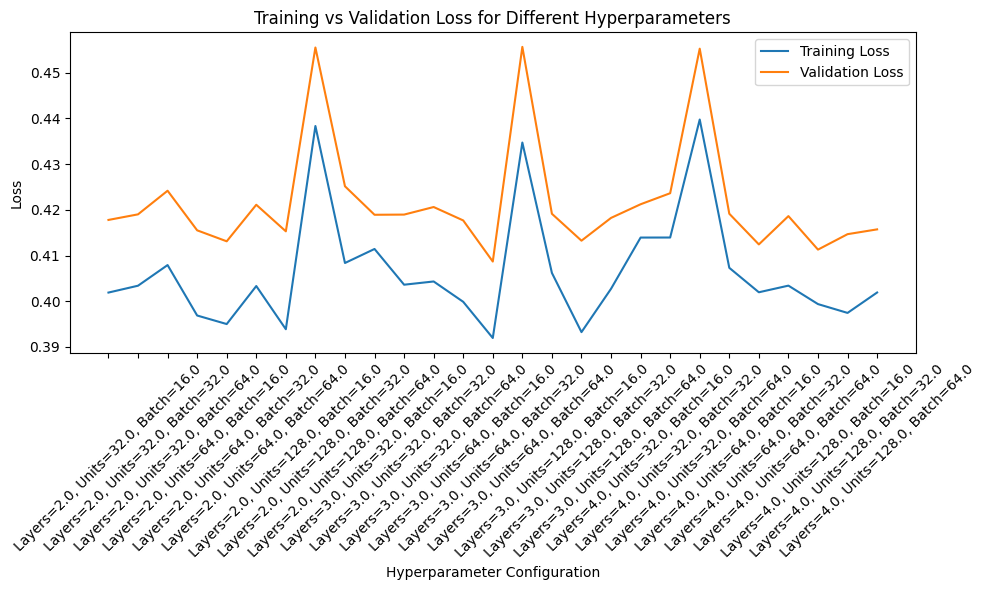

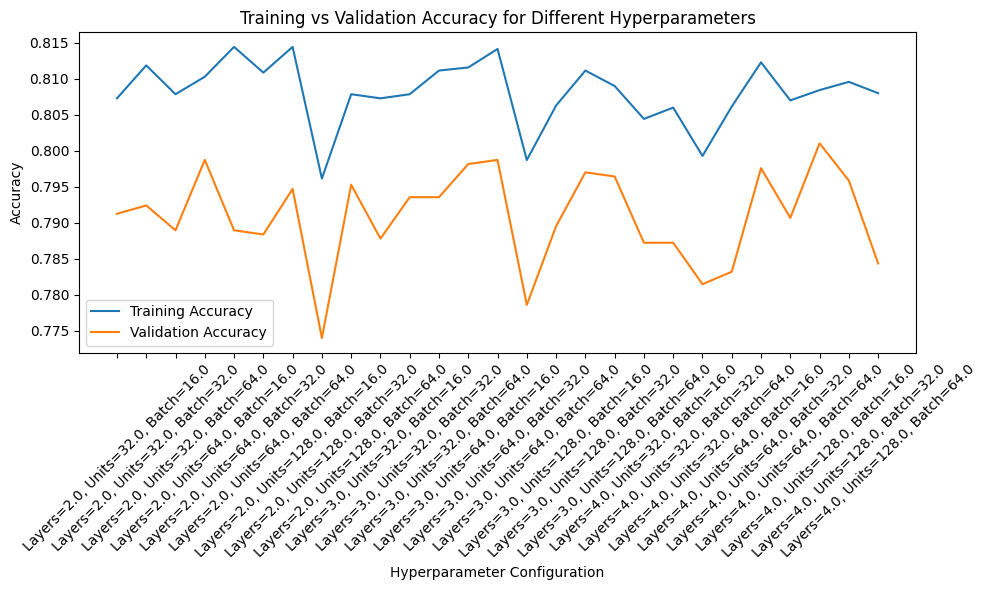

In [ ]:
results_df = pd.DataFrame(results)

# Create a unique identifier for each hyperparameter configuration for plotting
results_df['hyperparameter'] = results_df.apply(lambda row: f"Layers={row['num_layers']}, Units={row['additional_units']}, Batch={row['batch_size']}", axis=1)

# Plotting Training and Validation Loss
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='hyperparameter', y='train_loss', label='Training Loss')
sns.lineplot(data=results_df, x='hyperparameter', y='val_loss', label='Validation Loss')
plt.xticks(rotation=45)
plt.xlabel('Hyperparameter Configuration')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss for Different Hyperparameters')
plt.legend()
plt.tight_layout()
plt.show()

# Plotting Training and Validation Accuracy
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='hyperparameter', y='train_accuracy', label='Training Accuracy')
sns.lineplot(data=results_df, x='hyperparameter', y='val_accuracy', label='Validation Accuracy')
plt.xticks(rotation=45)
plt.xlabel('Hyperparameter Configuration')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy for Different Hyperparameters')
plt.legend()
plt.tight_layout()
plt.show()


### Visualizing Random Search Optimization
In this section, we explore the impact of varying dropout rates and learning rates on model performance. By using a random search approach, we can sample from a defined range of hyperparameters and then visualize how these parameters influence the training process and model accuracy. This visualization helps in understanding the sensitivity of the model to these hyperparameters and in identifying optimal values.


In [19]:
# Define the parameter space
param_grid = {
    'dropout_rate': np.linspace(0.1, 0.5, num=5),
    'learning_rate': np.logspace(-4, -2, num=5)
}
param_list = list(ParameterSampler(param_grid, n_iter=50, random_state=42))

# Store the results of each run
random_search_results = []

for params in param_list:
    model = Sequential(name='RandomSearchModel')
    model.add(Dense(128, activation='tanh', input_shape=(X_train_smote.shape[1],)))
    model.add(Dropout(params['dropout_rate']))
    model.add(Dense(128, activation='tanh'))
    model.add(Dropout(params['dropout_rate']))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=Adam(learning_rate=params['learning_rate']), loss='binary_crossentropy', metrics=['accuracy'])
    
    history = model.fit(X_train_smote, y_train_smote, validation_data=(X_val_enhanced, y_val_enhanced),
                        epochs=50, batch_size=32, verbose=0)
    
    # Record the best validation accuracy and corresponding parameters
    best_val_acc = max(history.history['val_accuracy'])
    random_search_results.append({
        'dropout_rate': params['dropout_rate'],
        'learning_rate': params['learning_rate'],
        'best_val_acc': best_val_acc
    })


/Users/rahulnundlall/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 25 is smaller than n_iter=50. Running 25 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


## Scatter Plot:
 Each point represents a different configuration tested during the random search. The x-axis shows the learning rate on a logarithmic scale, allowing for better visualization across orders of magnitude. The y-axis shows the best validation accuracy achieved with that configuration. Different colors represent different dropout rates, helping to discern how both learning rate and dropout rate jointly affect model performance.
 This approach provides a clear, visual understanding of how different hyperparameters affect model outcomes, guiding the selection of optimal values for these parameters.
## Contour Plots:
To improve the plots and add interpolation, we can use contour plots or heatmaps that interpolate the scattered data points to show a smoother gradient of performance across the hyperparameter space. This can give a more intuitive understanding of how different hyperparameters interact and affect the model performance.

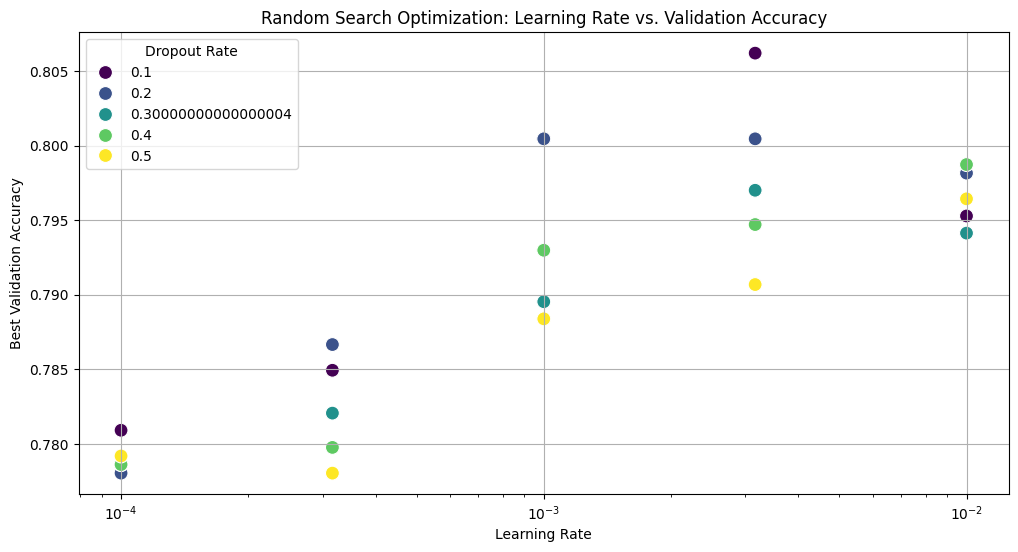

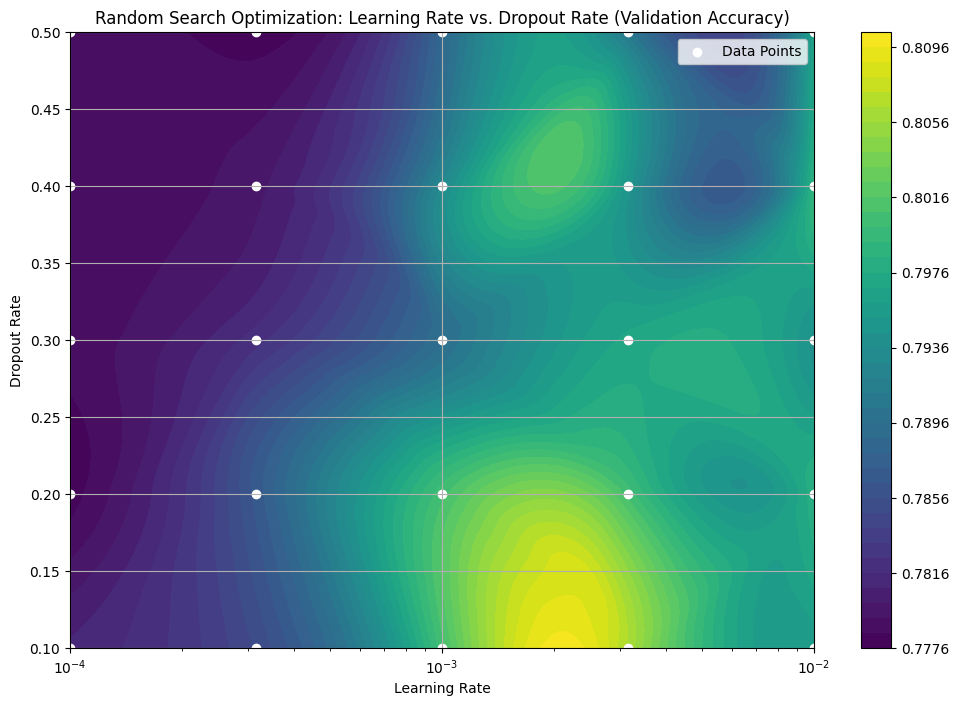

In [20]:
random_search_df = pd.DataFrame(random_search_results)
plt.figure(figsize=(12, 6))
sns.scatterplot(data=random_search_df, x='learning_rate', y='best_val_acc', hue='dropout_rate', palette='viridis', s=100)
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Best Validation Accuracy')
plt.title('Random Search Optimization: Learning Rate vs. Validation Accuracy')
plt.legend(title='Dropout Rate')
plt.grid(True)
plt.show()
# Prepare grid for interpolation
learning_rates = np.logspace(-4, -2, 100)
dropout_rates = np.linspace(0.1, 0.5, 100)
XX, YY = np.meshgrid(learning_rates, dropout_rates)

# Interpolate using griddata
ZZ = griddata((random_search_df['learning_rate'], random_search_df['dropout_rate']),
              random_search_df['best_val_acc'], (XX, YY), method='cubic')

# Plotting
plt.figure(figsize=(12, 8))
contour = plt.contourf(XX, YY, ZZ, levels=50, cmap='viridis')
plt.scatter(random_search_df['learning_rate'], random_search_df['dropout_rate'], c='white', label='Data Points')
plt.xscale('log')
plt.colorbar(contour)
plt.xlabel('Learning Rate')
plt.ylabel('Dropout Rate')
plt.title('Random Search Optimization: Learning Rate vs. Dropout Rate (Validation Accuracy)')
plt.legend()
plt.grid(True)
plt.show()